# Modelling
Author: ZHANG Yun

## Load packages and data

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import SparsePCA
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data and functions for selecting data are loaded from data_selectors.py
from data_selectors import *

In [3]:
COMMODITY_LIST = ['us corn', 'us soybeans', 'us wheat']

### Function for selecting data

In [4]:
data_corn = data_selector_news("us corn", 1)
data_corn.head()

58 rows of data are selected.


,date,type,words,us corn_close,us corn_close_trend
0,2020-06-17,us corn,corn spike high monday 's overnight electron s...,331.00,1.0
1,2020-03-10,us corn,march mad hand deck good morn ! nfib busi opti...,379.25,-1.0
2,2020-10-21,us corn,corn front grain complex present pace normal s...,416.25,1.0
3,2020-07-20,us corn,nbsp articl written exclus ethanol price rise ...,322.75,-1.0
4,2020-04-22,us corn,across commod univers loud rumbl carnag oil mo...,319.25,1.0


In [5]:
data_selector_tweet('us soybeans', "2020-01-01", "2020-02-01", plot=False).head()

,replies_count,retweets_count,likes_count,words,neg,neu,pos,us soybeans_close,us soybeans_trend_next
2020-01-01,0,0,2,drew yall peeptoemama crop insur yes low commo...,0.066,0.849,0.085,943.50,-1.0
2020-01-01,0,0,2,drew yall peeptoemama crop insur yes low commo...,0.000,0.863,0.137,943.50,-1.0
2020-01-01,0,1,1,establish farm beef cattl cash grain oilse cor...,0.066,0.849,0.085,943.50,-1.0
2020-01-01,0,1,1,establish farm beef cattl cash grain oilse cor...,0.000,0.863,0.137,943.50,-1.0
2020-01-02,0,0,4,specialti soybean varieti one way bring extra ...,0.000,0.915,0.085,943.25,-1.0


## TF-IDF

In [6]:
# Define a function to do the TF-IDF transform
def tfidf(X):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X), vectorizer

In [7]:
X, _ = tfidf(data_corn.words)
y = data_corn["us corn_close_trend"]
print(f"{X.shape}, {y.shape}")

(58, 2934), (58,)


Data we got after TF-IDF is sparse and high-dimensional, dimension reduction technique is required.

## Dimension Reduction
In this section, we use the SVD to do dimension reduction on the TF-IDF matrix.

In [8]:
def tfidf_svd(X, svd_cum_evr = 0.85, plot=False):
    """
    Do TF-IDF transform and SVD decomposition.
    Parameters:
        X           : corpus
        svd_cum_evr : minimum total explained variance ratio required for the selecting components of SVD
        plot        : whether display the screen plot
    Return:
        X_svd       : SVD selected components
        vectorizer  : TF-IDF vectorizer
        svd         : SVD transformer
    """
    X_tfidf, vectorizer = tfidf(X)
    svd = TruncatedSVD(n_components=X_tfidf.shape[0])
    X_svd = svd.fit_transform(X_tfidf.toarray())
    
    if svd.explained_variance_ratio_.sum() < svd_cum_evr:
        print(f"{svd.n_components} SVD components can explain {svd._explained_variance_ratio_.sum(): .3f} of total variance.")
    else:
        nc = np.argmax(np.cumsum(svd.explained_variance_ratio_) > svd_cum_evr)
        svd = TruncatedSVD(n_components=nc)
        X_svd = svd.fit_transform(X_tfidf)
        print(f"{svd.n_components} SVD components can explain {svd.explained_variance_ratio_.sum(): .3f} of total variance.")
    if plot:
        plt.plot(np.cumsum(svd.explained_variance_ratio_))
        plt.xlabel('number of components')
        plt.ylabel('SVD cumulative explained variance')
        plt.show()
    return X_svd, vectorizer, svd

In [9]:
X_corn, _, _ = tfidf_svd(data_corn.words, 0.85)

42 SVD components can explain  0.837 of total variance.


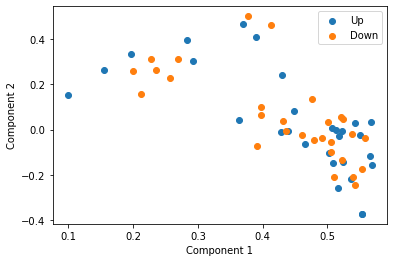

In [10]:
# Look the scatter plot of the first two components
plt.scatter(X_corn[y==1.0,0], X_corn[y==1.0,1], label="Up")
plt.scatter(X_corn[y==-1.0,0], X_corn[y==-1.0,1], label="Down")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()

## Classification

### News

In [11]:
nbc = GaussianNB()
nbc.fit(X_corn, data_corn["us corn_close_trend"])
confusion_matrix(data_corn["us corn_close_trend"], nbc.predict(X_corn))

array([[21,  8],
       [ 3, 26]], dtype=int64)

**************************************************
us corn
58 rows of data are selected.
There are 29 up records and 29 down records
42 SVD components can explain  0.837 of total variance.
[[22  7]
 [ 2 27]]
              precision    recall  f1-score   support

        -1.0       0.92      0.76      0.83        29
         1.0       0.79      0.93      0.86        29

    accuracy                           0.84        58
   macro avg       0.86      0.84      0.84        58
weighted avg       0.86      0.84      0.84        58

**************************************************
us soybeans
99 rows of data are selected.
There are 59 up records and 39 down records
67 SVD components can explain  0.843 of total variance.
[[37  2]
 [14 45]]
              precision    recall  f1-score   support

        -1.0       0.73      0.95      0.82        39
         1.0       0.96      0.76      0.85        59

    accuracy                           0.84        98
   macro avg       0.84      0.86  

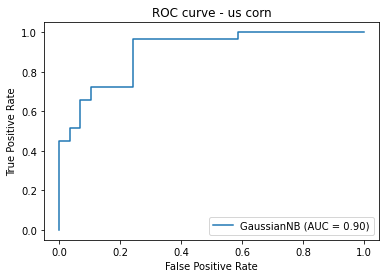

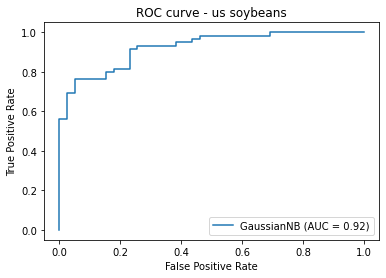

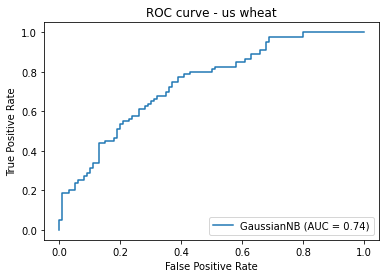

In [12]:
COMMODITY_LIST = ['us corn', 'us soybeans', 'us wheat']#, 'oats', 'rough rice']

for commodity in COMMODITY_LIST:
    print("*"*50)
    print(f"{commodity}")
    data = data_selector_news(commodity, 1)
    y = data[f"{commodity}_close_trend"]
#     y.replace(0, np.nan, inplace=True)
    print(f"There are {sum(y==1.0)} up records and {sum(y==-1.0)} down records")
    X, _, _ = tfidf_svd(data.words, 0.85)
    
    X = X[y.isna() == False,:]
    y = y.dropna()
    
    nbc = GaussianNB()
    nbc.fit(X, y)
    print(confusion_matrix(y, nbc.predict(X)))
    print(classification_report(y, nbc.predict(X)))
    metrics.plot_roc_curve(nbc, X, y)
    plt.title(f"ROC curve - {commodity}")

### Tweets

In [13]:
start = "2020-03-01"
end = "2020-06-01"
grain = 'us corn'

data = data_selector_tweet(grain, start, end, plot=False)
X = data[["neg", "neu", "pos"]].groupby(data.index).agg(['sum'])
y = data[f"{grain}_trend_next"].groupby(data.index).agg(['mean'])

In [14]:
clf = LogisticRegression(random_state=0).fit(X, y)
confusion_matrix(clf.predict(X), y)

array([[37, 26],
       [ 5, 10]], dtype=int64)

**************************************************
us corn
There are [36] up records and [42] down records from 2020-03-01 to 2020-06-01.
[[37  5]
 [26 10]]
              precision    recall  f1-score   support

        -1.0       0.59      0.88      0.70        42
         1.0       0.67      0.28      0.39        36

    accuracy                           0.60        78
   macro avg       0.63      0.58      0.55        78
weighted avg       0.62      0.60      0.56        78

**************************************************
us soybeans
There are [30] up records and [43] down records from 2020-03-01 to 2020-06-01.
[[43  0]
 [29  1]]
              precision    recall  f1-score   support

        -1.0       0.60      1.00      0.75        43
         1.0       1.00      0.03      0.06        30

    accuracy                           0.60        73
   macro avg       0.80      0.52      0.41        73
weighted avg       0.76      0.60      0.47        73

****************************

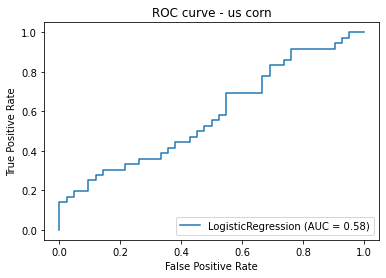

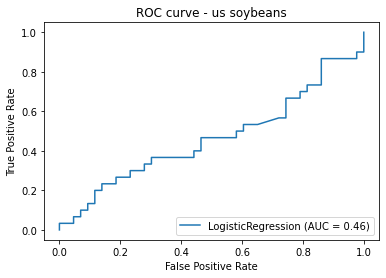

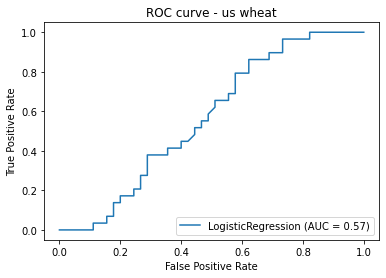

In [15]:
start = "2020-03-01"
end = "2020-06-01"

for commodity in COMMODITY_LIST:
    print("*"*50)
    print(f"{commodity}")
    data = data_selector_tweet(commodity, start, end, False)
    X = data[["neg", "neu", "pos"]].groupby(data.index).agg(['sum']).dropna()
    y = data[f"{commodity}_trend_next"].groupby(data.index).agg(['mean']).dropna()
    
    X = X[X.index.isin(y.index)]
    
    print(f"There are {sum(y.values==1.0)} up records and {sum(y.values==-1.0)} down records from {start} to {end}.")
    clf = LogisticRegression(random_state=0)
    clf.fit(X, y)
    print(confusion_matrix(y, clf.predict(X)))
    print(classification_report(y, clf.predict(X)))
    metrics.plot_roc_curve(clf, X, y)
    plt.title(f"ROC curve - {commodity}")

## Regression

In [16]:
grain = 'us wheat'
start = "2019-11-01"
end = "2020-01-01"
X = data_selector_tweet(grain, start, end, plot=False)
y = df_price.loc[start:end, [f"{grain}_close"]]

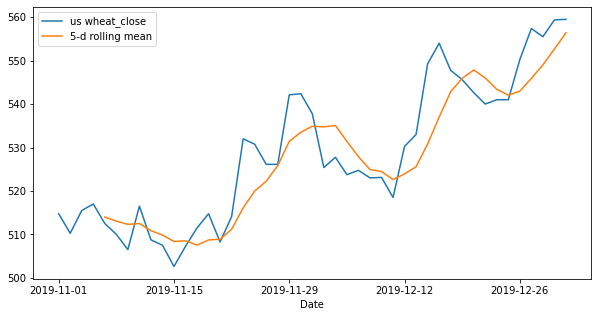

In [17]:
y['5-d rolling mean'] = y.rolling(5).mean()
y.plot(figsize=(10,5))

In [18]:
reg_data = pd.DataFrame(
    {
        'lag1': np.log(y[f"{grain}_close"]).shift(1),#diff().shift(),
        'lag2': np.log(y[f"{grain}_close"]).shift(2),#diff().shift(2),
        'y': np.log(y[f"{grain}_close"])#.diff()
    }
).dropna()

# pd.merge(y[f"{grain}_close"].diff().shift().dropna(),
#                     y[f"{grain}_close"].diff().dropna().iloc[1:],
#                     left_index=True, right_index=True)
reg_data = pd.merge(X.loc[:,['neg', 'neu', 'pos']].groupby(X.index).agg(['sum']), 
                    reg_data, left_index=True, right_index=True)

In [19]:
reg_data = sm.add_constant(reg_data)
reg_data.head(3)

,const,"(neg, sum)","(neu, sum)","(pos, sum)",lag1,lag2,y
2019-11-06,1.0,0.262,3.642,0.098,6.245137,6.234901,6.248043
2019-11-07,1.0,0.080,0.920,0.000,6.248043,6.245137,6.239301
2019-11-08,1.0,0.059,0.941,0.000,6.239301,6.248043,6.234411


In [20]:
result = sm.OLS(reg_data.iloc[:, -1], reg_data.iloc[:, :-1]).fit()

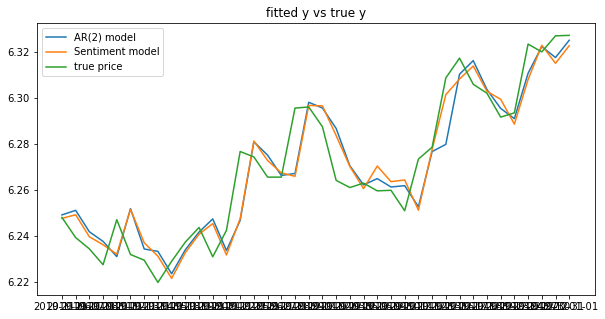

In [21]:
plt.figure(figsize=(10,5))
plt.plot(reg_data.index, sm.OLS(reg_data.iloc[:, -1], reg_data.iloc[:, [0,4,5]]).fit().fittedvalues, 
         label='AR(2) model')
plt.plot(reg_data.index, sm.OLS(reg_data.iloc[:, -1], reg_data.iloc[:, :-1]).fit().fittedvalues, 
         label='Sentiment model')
plt.plot(reg_data.index, reg_data.iloc[:, -1],  label='true price')
plt.title("fitted y vs true y")
plt.legend()
# pd.merge(result.fittedvalues, reg_data.iloc[:, -1], left_index=True, right_index=True).plot()

In [22]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     39.42
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           9.15e-13
Time:                        17:00:17   Log-Likelihood:                 114.86
No. Observations:                  38   AIC:                            -217.7
Df Residuals:                      32   BIC:                            -207.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5565      0.477      1.166      0.252      -0.415       1.528
('neg', 'sum')    -0.0007      0.002     -0.349      0.729      -0.005       0.004
('neu', 'sum')  -1.03e-05      0.000     -0.034      0.973      -0.001       0.001
('pos', 'sum')     0.0023      0.002      0.937      0.356      -0.003       0.007
lag1               1.0489      0.176      5.960      0.000       0.690       1.407
lag2              -0.1379      0.184     -0.751      0.458      -0.512       0.236
==============================================================================
Omnibus:                        4.321   Durbin-Watson:                   2.025
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.384
Skew:                           0.725   Prob(JB):                        0.184
Kurtosis:                       3.183   Cond. No.                     5.83e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Combine classification and regression

us soybeans:****************************************************************************************************
99 rows of data are selected.
7 SVD components can explain  0.803 of total variance.
Improvement of new model on adjusted R square: 0.003665806124795501
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     90.55
Date:                Sun, 06 Dec 2020   Prob (F-statistic):           4.63e-19
Time:                        17:00:29   Log-Likelihood:                 147.85
No. Observations:                  40   AIC:                            -281.7
Df Residuals:                      33   BIC:                            -269.9
Df Model:                           6                                         
Covariance Type:       

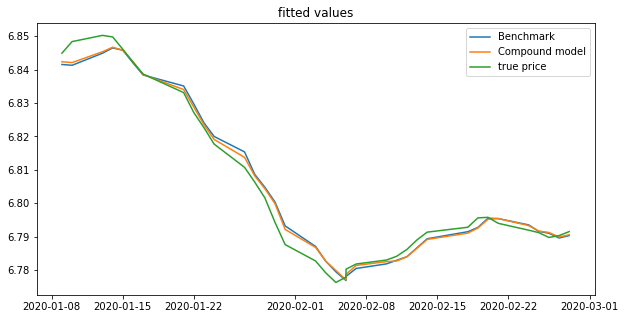

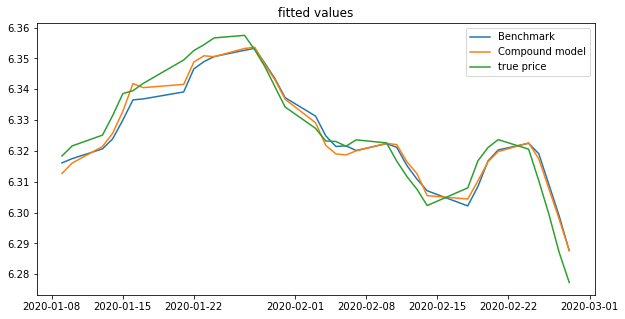

In [25]:
# Functions for training and testing compound regresison model are in the two cells below, run them first.
start = "2020-01-01"
end = "2020-03-01"
for grain in COMMODITY_LIST[1:]:
    print(f"{grain}:{'*'*100}")
    model =  model_train(grain, start, end)
    model_test(grain, "2019-06-02", "2019-09-01", model)

In [23]:
def reg_data_prep(grain, start, end, news_transformer = None):
    """
    prepare data for the compound regression
    """
    flag = 0
    data_news = data_selector_news(grain, 1)
    data_news.index = pd.to_datetime(data_news.date)
    data_news = data_news.loc[start:end, :]
    y = data_news[f"{grain}_close_trend"]
    if news_transformer:
        vectorizer = news_transformer['tfidf']
        svd = news_transformer['svd']
        X = svd.transform(vectorizer.transform(data_news.words).toarray())
        flag = 1
    else:
        X, vectorizer, svd = tfidf_svd(data_news.words, 0.85)
        news_transformer = {'tfidf': vectorizer, 'svd':svd}
    
    X_news = X[y.isna() == False,:]
    y_news = y.dropna()
    
    data = data_selector_tweet(grain, start, end, plot=False)
    X = data[["neg", "neu", "pos"]].groupby(data.index).agg(['sum'])
    y = data[f"{grain}_close"].groupby(data.index).agg(['mean']).rename({"mean":f"{grain}_close"}, axis=1)
    
    if flag == 1:
          return X_news, y_news, X, y
    else:
        return X_news, y_news, X, y, news_transformer

In [24]:
def model_train(grain, start, end):
    
    X_news, y_news, X, y, news_transformer = reg_data_prep(grain, start, end)
    
    # Train classifier based on news data
    nbc = GaussianNB()
    nbc.fit(X_news, y_news)
    news_predict_trend = pd.DataFrame(nbc.predict(X_news), index=y_news.index, columns=['npt'])
    
    # Combine data
    X2 = pd.merge(X, news_predict_trend, left_index=True, right_index=True, how="left")
    X2.npt = X2.npt.fillna(0)
    
    # Do regression
    reg_data = pd.DataFrame(
    {
        'lag1': np.log(y[f"{grain}_close"]).shift(1),#diff().shift(),
        'lag2': np.log(y[f"{grain}_close"]).shift(2),#diff().shift(2),
        'y': np.log(y[f"{grain}_close"])#.diff()
    })
    reg_data = sm.add_constant(pd.merge(X2, reg_data, left_index=True, right_index=True)).dropna()
    result = sm.OLS(reg_data.iloc[:, -1], reg_data.iloc[:, :-1]).fit()
    benchmark = sm.OLS(reg_data.iloc[:, -1], reg_data.iloc[:, [0,-3,-2]]).fit()
    
    model = {
        'news_transformer': news_transformer,
        'classifier': nbc,
        'regressor': result,
        'benchmark': benchmark
    }
    # Evaluation
    plt.figure(figsize=(10,5))
    plt.plot(reg_data.index, benchmark.fittedvalues.rolling(5).mean(), label='Benchmark')
    plt.plot(reg_data.index, result.fittedvalues.rolling(5).mean(), label='Compound model')
    plt.plot(reg_data.index, reg_data.iloc[:, -1].rolling(5).mean(),  label='true price')
    plt.title("fitted values")
    plt.legend()
    
    print(f"Improvement of new model on adjusted R square: {result.rsquared - benchmark.rsquared}")
    print(result.summary())
    return model
    
def model_test(grain, start, end, model):
    news_transformer, classifier, regressor, benchmark, = model.values()
    
    X_news, y_news, X, y = reg_data_prep(grain, start, end, news_transformer)
    print(len(X_news))
    if len(X_news) <= 1:
        news_predict_trend = pd.DataFrame(np.zeros((len(y), 1)), index=y.index, columns=['npt'])
    else:
        news_predict_trend = pd.DataFrame(classifier.predict(X_news), index=y_news.index, columns=['npt'])
    
    X2 = pd.merge(X, news_predict_trend, left_index=True, right_index=True, how="left")
    X2.npt = X2.npt.fillna(0)
    reg_data = pd.DataFrame(
    {
        'lag1': np.log(y[f"{grain}_close"]).shift(1),#diff().shift(),
        'lag2': np.log(y[f"{grain}_close"]).shift(2),#diff().shift(2),
        'y': np.log(y[f"{grain}_close"])#.diff()
    })
    reg_data = sm.add_constant(pd.merge(X2, reg_data, left_index=True, right_index=True)).dropna()
    y_pred = regressor.predict(reg_data.iloc[:, :-1])
    y_pred_b = benchmark.predict(reg_data.iloc[:, [0,-3,-2]])
    
    print(f"""On forecasting the price of {grain} commodity, R square and MSE of the two models are:
Compound regression model
    Predict R square: {r2_score(reg_data.y, y_pred):.4}\tMSE: {mean_squared_error(reg_data.y, y_pred):.4}
Benchmark model
    Predict R square: {r2_score(reg_data.y, y_pred_b):.4}\tMSE: {mean_squared_error(reg_data.y, y_pred_b):.4}
""")
    
    pass